# Adversarial Exmaples Tutorial

Welcome to this tutorial on adversarial examples! We know many of you are new to machine learning (some of you may be new to Python itself). We hope that this notebook serves as a light introduction to machine learning as well as to attacks on such models. Without further ado, let's head straight to it!


## Importing the libraries

We will be using `pytorch`, which is a popular framework for machine learning used by many researchers. I personally prefer this framework for its ease of extension, but many of the same methods here will apply to your framework of choice (Tensorflow, Keras, Jax). We begin by installing and importing the pytorch library as below (note that the necessary libraries are pre-installed on colab - your mileage will vary on other systems). We will also be importing a bunch of other libraries to load and display the fancy adversarial images you guys will be producing in this tutorial as well.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image               # to load images
from IPython.display import display # to display images
YOUR_CODE = None                    # placeholder to put your code

## Warmup: Tensor Kung Fu

We will start the tutorial with some simple operations to get yourself familiar with operating with Tensors. Tensors are in essence the lifeblood of machine learning - it is how inputs and outputs are defined over. To begin, let's load this pre-prepared tensor and see what's inside!

In [ ]:
!wget https://github.com/wongwaituck/adversarial-attack-ml-workshop/raw/main/tensor.pt
tensor = torch.load('tensor.pt')

Now that we have loaded the tensor, let's see what's inside!

In [ ]:
tensor

Perhaps that wasn't the best way of introspecting the tensor, but we see that a tensor is essentially some sort of large nested array. Let's quickly recap what an array is.

In [ ]:
# 1D array
arr_1d = [ 0, 1, 2 ]

# Let's access the first element of the array, arrays are 0-indexed in python
print(arr_1d[0])

# 2D array
# this is a array of arrays!
arr_2d = [
  [0, 1, 2],
  [10, 11, 12]
]

# Accessing the first element of an array of arrays returns *gasp*, an array
print(arr_2d[0])

# To access the element 2, we need to index into the array returned, like so:
print(arr_2d[0][2])

## TODO how do we access the element 12?
ans = YOUR_CODE


# We can similarly have a 3D array by nesting arr_2d in another array, as below:
arr_3d = [arr_2d]

#### TEST CASE
# assert(ans == 12)


A tensor is essentially an arbitrary nested array/matrix. If you don't believe me, lets look at the **shape** of a Tensor, which tells the degree of nesting and how the array looks like. We will first convert our 2D array into a pytorch tensor and look at it's shape. We can do so for the 3D array as well.

In [ ]:
tensor_2d = torch.Tensor(arr_2d)
print("2D Tensor Shape:", tensor_2d.shape)

tensor_3d = torch.Tensor(arr_3d)
print("3D Tensor Shape:", tensor_3d.shape)

We see that the 2D tensor shape is [2,3], which means there are 2 arrays, each containing 3 elements. We can check that this is true as above.

The 3D tensor shape also illustrates how the arrays are nested very clearly - we added the `arr_2d` as a single element in a list, and [1,2,3] simply describes that the array contains one `arr_2d`-like element. 

It is important to note that `arr_3d` is not the same as `arr_2d` since `arr_3d` is further nested by one additional array, and so we can't expect `tensor_3d` to be the same as `tensor_2d` either. Even though `[1,2,3]` looks like `[2,3]`, the degree of nesting is different, so take note! 

We can now observe the shape of our saved tensor to try to figure out what it looks like.

In [ ]:
tensor.shape

The code should return `[4,3,32,32]`. This is very typical of a image input tensor, which is structured in the following way:

$$ (nBatch, channels, height, width) $$

where `nBatch` is the number of input images, `channels` is the number of color channels (e.g. R, G, B), `height` refers to the height of the image in terms of the number of pixels and `width` refers to the width of the image in terms of the number of pixels.

In our case, this `tensor` is an image tensor with 4 images, each image has 3 color channels, and the height and width of each image is 32x32 respectively. This is good to recognize since it is very commonly used in the image setting, so we hope this tutorial helps you to understand tensors and their shapes.

Congratulations! You are a tensor expert now ;)

## Babby's First Classification Model

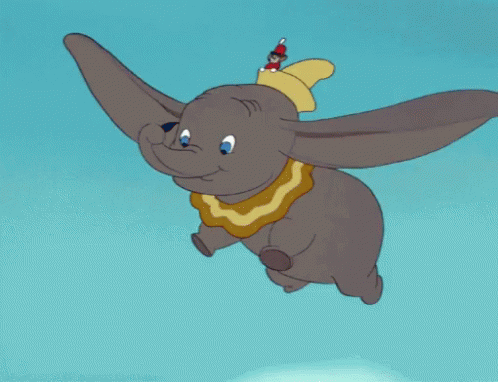

Elephants can fly, and so can planes. Can our machine learning model tell the difference?

Let's train a model to do just precisely that!

Most of the code is taken online, in particular the pytorch tutorial here: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [ ]:
# load the data

!wget https://github.com/wongwaituck/adversarial-attack-ml-workshop/raw/main/data.zip
!unzip data.zip

torch.manual_seed(123)

transform = transforms.Compose(
    [transforms.Resize((32,32),interpolation=transforms.InterpolationMode.NEAREST),
     transforms.ToTensor()])

batch_size = 4

trainset = torchvision.datasets.ImageFolder(root='./train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.ImageFolder(root='./test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1)

classes = ('elephant', 'plane')

In [ ]:
# display the image
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
torch.save(images, "tensor.pt")
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [ ]:
# define the network 
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 2, 3)
        self.maxpool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(450, 300)
        self.fc2 = nn.Linear(300, 2)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net()

In [ ]:
# let's visualize the model
%matplotlib inline
!pip install torchviz
from torchviz import make_dot

inputs = torch.randn_like(images)
print(inputs.shape)
y = net(torch.autograd.Variable(images))

g = make_dot(y)
g

In [ ]:
# train the model
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

In [ ]:
# test 
dataiter = iter(testloader)
images, labels = dataiter.next()

# eval the model on the image
outputs = net(images)
_, predicted = torch.max(outputs.data, 1)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Model Output: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [ ]:
# how does it perform on the whole dataset?
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 200 test images: %d %%' % (
    100 * correct / total))

How does it perform on our favourite flying elephant?

![](https://cdn-www.comingsoon.net/assets/uploads/gallery/dumbo-live-action/dxf76amvsaur5j.jpg)

In [ ]:
# try out on a image on the internet
!wget https://akns-images.eonline.com/eol_images/Entire_Site/201904/rs_600x600-190104141116-600-dumbo.jpg

# load image
img = Image.open('rs_600x600-190104141116-600-dumbo.jpg').convert('RGB')
img_tensor = transform(img)
img_tensor = img_tensor.reshape(1,3,32,32)

# eval the model on the image
outputs = net(img_tensor)
_, predicted = torch.max(outputs.data, 1)

# show the result
imshow(torchvision.utils.make_grid(img_tensor))
print('Classification: ', ' '.join('%5s' % classes[predicted] for j in range(1)))


## Babby's First Adversarial Attack

In [ ]:
# take an elephant picture
dataiter = iter(testloader)
images, labels = dataiter.next()
attack_image = images[0]
attack_image = torch.stack([attack_image])
attack_label = labels[0].reshape((1,))

# eval the model on the image
outputs = net(attack_image)
_, predicted = torch.max(outputs.data, 1)

# print images
imshow(torchvision.utils.make_grid(attack_image))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(1)))
print('Model Output: ', classes[predicted])

In [ ]:
# allow the attack image to be updated
attack_image.requires_grad = True
# target the plane label
target_label = torch.LongTensor([1,])

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image - epsilon*sign_data_grad
    # Adding clipping to maintain the correct image value ranges
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

attack_image_final = attack_image.clone()

for epoch in range(15): 
      # Zero all existing gradients
      net.zero_grad()
      # forward + backward + optimize
      attack_image_init = attack_image_final.clone()
      outputs = net(attack_image_init)
      # targeted attack - we want to optimize towards that label
      loss = criterion(outputs, target_label)
      print(loss)
      # run the backwards pass to get the gradient computation
      loss.backward(retain_graph=True)
      # Collect datagrad
      data_grad = attack_image.grad.data

      # do i-fgsm
      epsilon = 0.01 # max change
      attack_image_final = fgsm_attack(attack_image_final, epsilon, data_grad)

print('Finished Training Adversarial Sample')

In [ ]:
# eval the model on the image
baseline_attack_image = attack_image_final
outputs = net(baseline_attack_image)
print(outputs)
_, predicted = torch.max(outputs.data, 1)

imshow(torchvision.utils.make_grid(torch.cat([attack_image, baseline_attack_image])))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(1)))
print('Model Output: ', classes[predicted])

## Adversarial Attack Defense: Adversarial Training

In [ ]:
# adversarial training
net = Net()

# get adversarial samples
# allow the attack image to be updated
def adv_sample(model, images, labels):
    # FGSM attack code
    def fgsm_attack(image, epsilon, data_grad):
        # Collect the element-wise sign of the data gradient
        sign_data_grad = data_grad.sign()
        # Create the perturbed image by adjusting each pixel of the input image
        perturbed_image = image - epsilon*sign_data_grad
        # Adding clipping to maintain the correct image value ranges
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        # Return the perturbed image
        return perturbed_image

    attack_image_final = images.clone()

    for epoch in range(15): 
          # Zero all existing gradients
          model.zero_grad()
          # forward + backward + optimize
          attack_image_init = attack_image_final.clone()
          outputs = model(attack_image_init)
          # untargeted attack - we want to maximize the loss! so just take the negation
          loss = -criterion(outputs, labels)
          # run the backwards pass to get the gradient computation
          loss.backward(retain_graph=True)
          # Collect datagrad
          data_grad = attack_image.grad.data

          # do i-fgsm
          epsilon = 0.01 # max change
          attack_image_final = fgsm_attack(attack_image_final, epsilon, data_grad)
    return attack_image_final

print('Finished Training Adversarial Sample')

# train the model
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # get the fgsm'd version of the inputs
        attack_inputs = inputs.clone()
        attack_inputs.requires_grad = True
        adv_inputs = adv_sample(net, attack_inputs, labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

In [ ]:
# evaluate accuracy
# how does it perform on the whole dataset?
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 200 test images: %d %%' % (
    100 * correct / total))

In [ ]:
# check if the attack image still works
# eval the model on the image
outputs = net(baseline_attack_image)
print(outputs)
_, predicted = torch.max(outputs.data, 1)

imshow(torchvision.utils.make_grid(torch.cat([attack_image, baseline_attack_image])))
print('GroundTruth: elephant')
print('Model Output: ', classes[predicted])